In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pykat

pykat.init_pykat_plotting(fmts=['png'])

                                              ..-
    PyKat 1.1.244         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat



In [2]:
data1 = np.loadtxt("20180423_SQZ_OMC_Scan_ASCon_Lens_Center.txt")
data2 = np.loadtxt("20180423_SQZ_OMC_Scan_ASCon_Lens_Center3.txt")

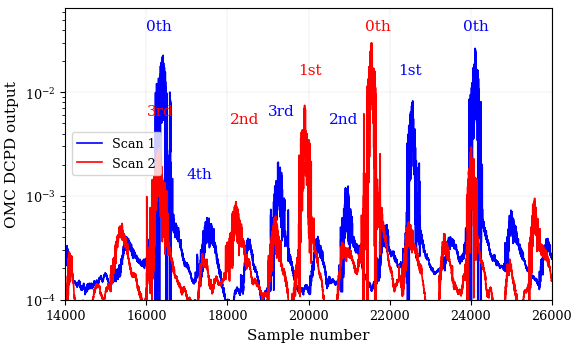

In [3]:
plt.figure()

# ax = plt.subplot(211)
plt.semilogy(data1[::1,2] - data1[::1,2].min()       -2.9e-3, label="Scan 1")
plt.semilogy(data2[::1,2] - data2[::1,2].min()-2.3e-3-2.9e-3, label="Scan 2")
plt.ylim(1e-4, None)
plt.ylabel("OMC DCPD Counts")
plt.legend(loc="center left")

plt.text(23800, 4e-2, "0th", color='b')
plt.text(22200, 1.5e-2, "1st", color='b')
plt.text(20500, 0.5e-2, "2nd", color='b')
plt.text(19000, 0.6e-2, "3rd", color='b')
plt.text(17000, 0.15e-2, "4th", color='b')
plt.text(16000, 4e-2, "0th", color='b')

plt.text(23800-2400, 4e-2, "0th",   color='r')
plt.text(22200-2450, 1.5e-2, "1st", color='r')
plt.text(20500-2450, 0.5e-2, "2nd", color='r')
plt.text(19000-3000, 0.6e-2, "3rd", color='r')

plt.xlim(14000, 26000)
plt.xlabel("Sample number")
plt.ylabel("OMC DCPD output")
plt.tight_layout()

In [218]:
kat = pykat.finesse.kat()
kat.verbose = False
kat.parse("""
l l1 1 0 n1
bs m1 1 0 0 0 n1 n2 dump dump
s s0 2 n2 n3
bs m2 1 0 0 0 n3 n4 dump dump
s s1 100 n4 nOMC_ICa

###########################################################################
# OMC (as built parameters: D1300507-v1)
# Input Coupler IC (flat mirror)
bs1 OMC_IC 0.0076 1e-05 0.0 2.7609 nOMC_ICa nOMC_ICb nOMC_ICc nOMC_ICd
# Distance from IC to OC
s lIC_OC 0.2815 nOMC_ICc nOMC_OCa
# Output Coupler OC (flat mirror)
bs1 OMC_OC 0.0075 1e-05 0.0 4.004 nOMC_OCa nOMC_OCb nAS nOMC_OCd
# Distance from OC to CM1
s lOC_CM1 0.2842 nOMC_OCb nOMC_CM1a
# Curved Mirror CM1
bs1 OMC_CM1 3.6e-05 1e-05 0.0 4.004 nOMC_CM1a nOMC_CM1b nOMC_CM1c nOMC_CM1d
attr OMC_CM1 Rcx 2.57321
attr OMC_CM1 Rcy 2.57321
# Distance from CM1 to CM2
s lCM1_CM2 0.2815 nOMC_CM1b nOMC_CM2a
# Curved Mirror CM2
bs1 OMC_CM2 3.59e-05 1e-05 0.0 4.004 nOMC_CM2a nOMC_CM2b nOMC_CM2c nOMC_CM2d
attr OMC_CM2 Rcx 2.57369
attr OMC_CM2 Rcy 2.57369
# Distance from CM2 to IC
s lCM2_IC 0.2842 nOMC_CM2b nOMC_ICd
###########################################################################

cav cavOMC OMC_IC nOMC_ICc OMC_IC nOMC_ICd
cp OMC_FSR cavOMC x fsr
cp OMC_B cavOMC x B
bp q_in x q n1

xaxis l1 f lin 0 1000M 5001

pd P nAS

tem l1 0 0 1   0
#tem l1 1 0 0.1 0
#tem l1 3 0 0.05 0

maxtem 6
yaxis re:im
""")

kat.noxaxis = True
out = kat.run()

FSR = abs(out['OMC_FSR'])
qi  = -pykat.BeamParam(q=out['q_in']).conjugate()

def run(kat, qo):
    kat.l1.n1.q = qo
    kat.xaxis.limits = [-0.1*FSR, 1.1*FSR]
    kat.noxaxis = False

    out = kat.run(cmd_args=["-cr=on"])
    
    select = np.where(np.logical_and(out.x >= -0.1e8, out.x <= 0.1e8))
    O0 = abs(out['P'][select].max())

    select = np.where(np.logical_and(out.x >= 0.5e8, out.x <= 1e8))
    O1 = abs(out['P'][select].max())

    select = np.where(np.logical_and(out.x >= 1e8, out.x <= 1.3e8))
    O2 = abs(out['P'][select].max())

    select = np.where(np.logical_and(out.x >= 2.2e8, out.x <= 2.4e8))
    O4 = abs(out['P'][select].max())

    return out, pykat.BeamParam.overlap(qi,qo), O0,O1,O2,O4

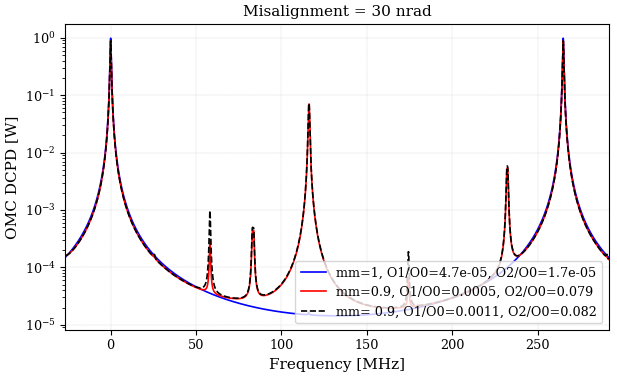

In [233]:
plt.figure(figsize=(4*1.6, 4))
misalignment = 3e-8

kat.m1.xbeta = 0e-7
kat.m2.xbeta = 0e-7
qo           = pykat.BeamParam(w0=qi.w0*1, z=qi.z*1.00) 
out, mm, O0, O1, O2, O4 = run(kat, qo)
plt.semilogy(out.x/1e6, abs(out['P']), label="mm=%.2g, O1/O0=%.2g, O2/O0=%.2g" % (mm, O1/O0, O2/O0))

kat.m1.xbeta = -misalignment
kat.m2.xbeta =  misalignment

qo           = pykat.BeamParam(w0=qi.w0*1.38, z=qi.z*1.00) 
out, mm, O0, O1, O2, O4 = run(kat, qo)
plt.semilogy(out.x/1e6, abs(out['P']), label="mm=%.2g, O1/O0=%.2g, O2/O0=%.2g" % (mm, O1/O0, O2/O0))


qo           = pykat.BeamParam(w0=qi.w0*0.72, z=qi.z*1.00) 
out, mm, O0, O1, O2, O4 = run(kat, qo)
plt.semilogy(out.x/1e6, abs(out['P']), label="mm=%4.g, O1/O0=%.2g, O2/O0=%.2g" % (mm, O1/O0, O2/O0), ls='--')


plt.title("Misalignment = %g nrad" % (misalignment/1e-9))
plt.xlabel("Frequency [MHz]")
plt.ylabel("OMC DCPD [W]")
plt.legend(loc="lower right")
plt.tight_layout()

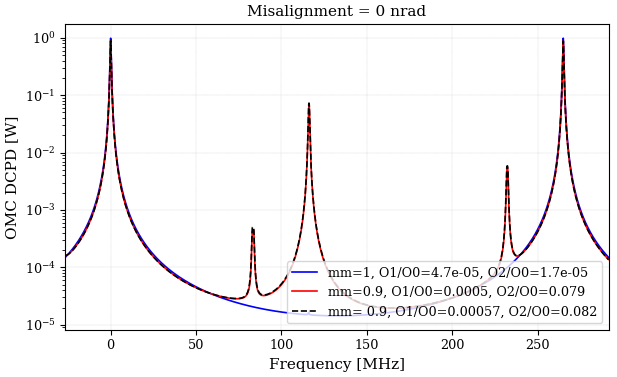

In [224]:
plt.figure(figsize=(4*1.6, 4))
misalignment = 0e-7

kat.m1.xbeta = 0e-7
kat.m2.xbeta = 0e-7
qo           = pykat.BeamParam(w0=qi.w0*1, z=qi.z*1.00) 
out, mm, O0, O1, O2, O4 = run(kat, qo)
plt.semilogy(out.x/1e6, abs(out['P']), label="mm=%.2g, O1/O0=%.2g, O2/O0=%.2g" % (mm, O1/O0, O2/O0))

kat.m1.xbeta = -misalignment
kat.m2.xbeta =  misalignment

qo           = pykat.BeamParam(w0=qi.w0*1.38, z=qi.z*1.00) 
out, mm, O0, O1, O2, O4 = run(kat, qo)
plt.semilogy(out.x/1e6, abs(out['P']), label="mm=%.2g, O1/O0=%.2g, O2/O0=%.2g" % (mm, O1/O0, O2/O0))


qo           = pykat.BeamParam(w0=qi.w0*0.72, z=qi.z*1.00) 
out, mm, O0, O1, O2, O4 = run(kat, qo)
plt.semilogy(out.x/1e6, abs(out['P']), label="mm=%4.g, O1/O0=%.2g, O2/O0=%.2g" % (mm, O1/O0, O2/O0), ls='--')


plt.title("Misalignment = %g nrad" % (misalignment/1e-9))
plt.xlabel("Frequency [MHz]")
plt.ylabel("OMC DCPD [W]")
plt.legend(loc="lower right")
plt.tight_layout()

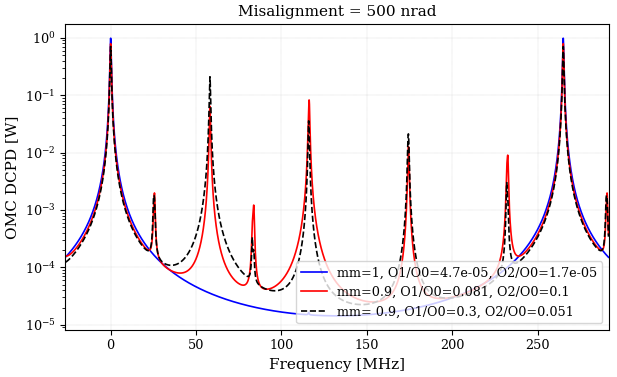

In [235]:
plt.figure(figsize=(4*1.6, 4))
misalignment = 5e-7

kat.m1.xbeta = 0e-7
kat.m2.xbeta = 0e-7
qo           = pykat.BeamParam(w0=qi.w0*1, z=qi.z*1.00) 
out, mm, O0, O1, O2, O4 = run(kat, qo)
plt.semilogy(out.x/1e6, abs(out['P']), label="mm=%.4g, O1/O0=%.2g, O2/O0=%.2g" % (mm, O1/O0, O2/O0))

kat.m1.xbeta = -misalignment
kat.m2.xbeta =  misalignment

qo           = pykat.BeamParam(w0=qi.w0*1.38, z=qi.z*1.00) 
out, mm, O0, O1, O2, O4 = run(kat, qo)
plt.semilogy(out.x/1e6, abs(out['P']), label="mm=%.2g, O1/O0=%.2g, O2/O0=%.2g" % (mm, O1/O0, O2/O0))


qo           = pykat.BeamParam(w0=qi.w0*0.72, z=qi.z*1.00) 
out, mm, O0, O1, O2, O4 = run(kat, qo)
plt.semilogy(out.x/1e6, abs(out['P']), label="mm=%4.g, O1/O0=%.2g, O2/O0=%.2g" % (mm, O1/O0, O2/O0), ls='--')


plt.title("Misalignment = %g nrad" % (misalignment/1e-9))
plt.xlabel("Frequency [MHz]")
plt.ylabel("OMC DCPD [W]")
plt.legend(loc="lower right")
plt.tight_layout()